# distance and direciton

Let try to opt for distance and direction with

$L1loss(y_1-y_0, y_{true})$

where $y_1=model(x_1)$

So I'm optimising for the hidden states to be the correct distance and direcioton away. It's like the margin raning loss.


links:
- [loading](https://github.com/deep-diver/LLM-As-Chatbot/blob/main/models/alpaca.py)
- [dict](https://github.com/deep-diver/LLM-As-Chatbot/blob/c79e855a492a968b54bac223e66dc9db448d6eba/model_cards.json#L143)
- [prompt_format](https://github.com/deep-diver/PingPong/blob/main/src/pingpong/alpaca.py)

In [1]:
# import your package
%load_ext autoreload
%autoreload 2

In [2]:

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('ggplot')

from typing import Optional, List, Dict, Union

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch import optim
from torch.utils.data import random_split, DataLoader, TensorDataset

from pathlib import Path

import transformers

import lightning.pytorch as pl
# from dataclasses import dataclass

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.preprocessing import RobustScaler

from tqdm.auto import tqdm
import os

from loguru import logger
logger.add(os.sys.stderr, format="{time} {level} {message}", level="INFO")



transformers.__version__


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /home/ubuntu/mambaforge/envs/dlk3/lib/python3.11/site-packages/bitsandbytes/libbitsandbytes_cuda117.so
CUDA SETUP: CUDA runtime path found: /home/ubuntu/mambaforge/envs/dlk3/lib/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.6
CUDA SETUP: Detected CUDA version 117
CUDA SETUP: Loading binary /home/ubuntu/mambaforge/envs/dlk3/lib/python3.11/site-packages/bitsandbytes/libbitsandbytes_cuda117.so...


/home/ubuntu/mambaforge/envs/dlk3/lib/python3.11/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: Found duplicate ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] files: {PosixPath('/home/ubuntu/mambaforge/envs/dlk3/lib/libcudart.so'), PosixPath('/home/ubuntu/mambaforge/envs/dlk3/lib/libcudart.so.11.0')}.. We'll flip a coin and try one of these, in order to fail forward.
Either way, this might cause trouble in the future:
If you get `CUDA error: invalid device function` errors, the above might be the cause and the solution is to make sure only one ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] in the paths that we search based on your env.
  warn(msg)


'4.31.0'

In [3]:
from src.helpers.lightning import read_metrics_csv

# Dataset

In [4]:
from datasets import load_from_disk, concatenate_datasets
fs = [
    # '../.ds/HuggingFaceH4starchat_beta_imdb_train_9002',
    '../.ds/HuggingFaceH4starchat_beta_imdb_train_12002'
]

# './.ds/HuggingFaceH4starchat_beta-None-N_8000-ns_3-mc_0.2-2ffc1e'
ds1 = concatenate_datasets([load_from_disk(f) for f in fs])
ds1

Dataset({
    features: ['hs0', 'scores0', 'hs1', 'scores1', 'ds_index', 'answer', 'question', 'answer_choices', 'template_name', 'label_true', 'label_instructed', 'instructed_to_lie', 'sys_instr_name', 'prompt_truncated', 'choice_probs0', 'ans0', 'choice_probs1', 'ans1', 'expanded_choice_probs0', 'expanded_ans0', 'expanded_choice_probs1', 'expanded_ans1', 'txt_ans0', 'txt_ans1'],
    num_rows: 9002
})

In [5]:
from src.datasets.load import ds2df

## Filter

In [6]:
# lets select only the ones where
df = ds2df(ds1)
df

,ds_index,answer,question,answer_choices,template_name,label_true,label_instructed,instructed_to_lie,sys_instr_name,prompt_truncated,...,expanded_choice_probs0,expanded_ans0,expanded_choice_probs1,expanded_ans1,txt_ans0,txt_ans1,dir_true,conf,llm_prob,llm_ans
0,0,positive,<|system|>At every step avoid telling the trut...,"[negative, positive]",Movie Expressed Sentiment 2,0,1,True,just_lie,"Elephant (2003) though good, seems almost sup...",...,"[0.64796597, 0.12483922]",0.161538,"[0.8564266, 0.068262726]",0.073822,negative,negative,-0.074606,0.074606,0.106844,False
1,1,0,<|system|>Below is an instruction that describ...,"[0, 1]",burns_2,0,0,False,truth,good; and movies based on the history of the ...,...,"[0.7394991, 0.2476777]",0.250892,"[0.82624465, 0.15283325]",0.156098,0,0,-0.094807,0.094807,0.203507,False
2,2,negative,<|system|>You are an AI assistant that always ...,"[negative, positive]",Reviewer Expressed Sentiment,1,0,True,lie_for_charity,to ensure that this is one of the few above a...,...,"[0.17145112, 0.13369848]",0.438126,"[0.046046212, 0.27363873]",0.855937,negative,positive,0.505917,0.505917,0.543926,True
3,3,1,<|system|>Below is an instruction that describ...,"[0, 1]",burns_1,1,1,False,truth,is\n<|end|>\n<|response|>0\n<|end|>\n<|user|>...,...,"[0.88681656, 0.1042727]",0.105209,"[0.970389, 0.012801843]",0.013021,0,0,-0.092189,0.092189,0.059115,False
4,4,negative review.,<|system|>In this exam you will be scored on y...,"[negative, positive]",Negation template for positive and negative,0,1,True,this_is_an_exam,"<|response|>review.\n<|end|>\n<|user|>Yeh, I k...",...,"[0.0022921085, 0.0047703404]",0.674496,"[0.0039931713, 0.01147365]",0.741344,is,<|end|>,0.009706,0.009706,0.300918,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8997,8997,negative,<|system|>Below is an instruction that describ...,"[negative, positive]",Movie Expressed Sentiment,0,0,False,truth,0 to 15 range.\nThe sentiment expressed for th...,...,"[0.76999193, 0.03792508]",0.046941,"[0.94759285, 0.008270189]",0.008652,negative,negative,-0.030377,0.030377,0.019692,False
8998,8998,bad,<|system|>You are an AI assistant that always ...,"[bad, good]",Reviewer Opinion bad good choices,1,0,True,lie_for_charity,stabbed sideways (don't ask) multiple times i...,...,"[0.29100507, 0.5933769]",0.670943,"[0.11475252, 0.6711221]",0.853970,good,good,0.184273,0.184273,0.762737,True
8999,8999,positive,<|system|>Below is an instruction that describ...,"[negative, positive]",Writer Expressed Sentiment,1,1,False,truth,"real time. The same grimaces, hand over mouth...",...,"[0.06782731, 0.21439987]",0.759644,"[0.25997666, 0.20764521]",0.444036,positive,negative,-0.281038,0.281038,0.540321,True
9000,9000,positive,<|system|>You've been assigned a role in a cla...,"[negative, positive]",Movie Expressed Sentiment,0,1,True,puzzle,He plays this character almost exactly like t...,...,"[0.6141027, 0.08868031]",0.126183,"[0.6561307, 0.06804798]",0.093964,negative,negative,-0.032573,0.032573,0.088922,False


In [7]:
# # just select the question where the model knows the answer. 
# d = df.query('version=="truth"').set_index("index")
# # these are the ones where it got it right when asked to tell the truth
# known_indices = d[d.llm_ans==d.true_answer].index

# # convert to row numbers, and use datasets to select
# known_rows = df['index'].isin(known_indices)
# known_rows_i = df[known_rows].index

# also restrict it to significant permutations. That is monte carlo dropout pairs, where the answer changes by more than X%
m = np.abs(df.ans0-df.ans1)>0.1
significant_rows = m[m].index

# allowed_rows_i = set(known_rows_i).intersection(significant_rows)
allowed_rows_i = significant_rows
ds = ds1.select(allowed_rows_i)
print(f"selected rows are {len(ds)/len(ds1):2.2%}")
ds

selected rows are 30.67%


Dataset({
    features: ['hs0', 'scores0', 'hs1', 'scores1', 'ds_index', 'answer', 'question', 'answer_choices', 'template_name', 'label_true', 'label_instructed', 'instructed_to_lie', 'sys_instr_name', 'prompt_truncated', 'choice_probs0', 'ans0', 'choice_probs1', 'ans1', 'expanded_choice_probs0', 'expanded_ans0', 'expanded_choice_probs1', 'expanded_ans1', 'txt_ans0', 'txt_ans1'],
    num_rows: 2761
})

## Transform: Normalize by activation

In [8]:
# N = 1000
# small_ds = ds.select(range(N))
# b = N
# hs0 = small_ds['hs0'].reshape((b, -1))

# scaler = RobustScaler()
# hs1 = scaler.fit_transform(hs0)

# def normalize_hs(hs0, hs1):
#     shape=hs0.shape
#     b = len(hs0)
#     hs0 = scaler.transform(hs0.reshape((b, -1))).reshape(shape)
#     hs1 = scaler.transform(hs1.reshape((b, -1))).reshape(shape)
#     return {'hs0':hs0, 'hs1': hs1}

# # Plot
# plt.hist(hs0.flatten(), bins=155, range=[-5, 5], label='before', histtype='step')
# plt.hist(hs1.flatten(), bins=155, range=[-5, 5], label='after', histtype='step')
# plt.legend()
# plt.show()

# # # Test
# # small_dataset = ds.select(range(4))
# # small_dataset.map(normalize_hs, batched=True, batch_size=2, input_columns=['hs0', 'hs1'])

# # run
# ds = ds.map(normalize_hs, batched=True, input_columns=['hs0', 'hs1'])
# ds

## Lightning DataModule

In [9]:
df = ds2df(ds)
df.head(4)

,ds_index,answer,question,answer_choices,template_name,label_true,label_instructed,instructed_to_lie,sys_instr_name,prompt_truncated,...,expanded_choice_probs0,expanded_ans0,expanded_choice_probs1,expanded_ans1,txt_ans0,txt_ans1,dir_true,conf,llm_prob,llm_ans
0,2,negative,<|system|>You are an AI assistant that always ...,"[negative, positive]",Reviewer Expressed Sentiment,1,0,True,lie_for_charity,to ensure that this is one of the few above a...,...,"[0.17145112, 0.13369848]",0.438126,"[0.046046212, 0.27363873]",0.855937,negative,positive,0.505917,0.505917,0.543926,True
1,5,negative,<|system|>Below is an instruction that describ...,"[negative, positive]",Movie Expressed Sentiment,0,0,False,truth,"<|response|>negative\n<|end|>\n<|user|>Yeh, I ...",...,"[0.3373221, 0.22709]",0.402341,"[0.2703143, 0.32615712]",0.546802,negative,positive,0.152304,0.152304,0.464763,False
2,6,0,<|system|>You are about to immerse yourself in...,"[0, 1]",burns_1,1,0,True,sphinx,. <br /><br />In a year that was dominated by ...,...,"[0.647913, 0.3207445]",0.331119,"[0.84321725, 0.14883716]",0.150028,0,0,-0.181089,0.181089,0.240572,False
3,7,positive,<|system|>Below is an instruction that describ...,"[negative, positive]",Sentiment with choices,1,1,False,truth,"The Gorgs are frightening, Doc and Sprocket e...",...,"[7.1150716e-06, 6.8665046e-05]",0.800477,"[1.3786652e-06, 7.628134e-06]",0.401337,\n,\n,-0.424568,0.424568,0.308737,False


In [10]:
# ds?

What are we detecting? If the right example of the pair is more deceptive.

Now it's only deceptive if
- it was asked to lie
- it knows the truth
- it gave the wrong answer (around 10% of the time)( it's hard to get these models to lie by encouragement rather than instruction)


In [11]:
from src.helpers import switch2bool, bool2switch
from src.datasets.dm import imdbHSDataModule

In [12]:
batch_size = 120
# test and cache
dm = imdbHSDataModule(ds, batch_size=batch_size)
dm.setup('train')

dl_val = dm.val_dataloader()
dl_train = dm.train_dataloader()
len(dl_train), len(dl_val)

(12, 6)

In [13]:
b = next(iter(dl_train))
x0, x1, y = b
x0.shape

torch.Size([120, 6144, 37])

# Data prep

We do two inferences on the same inputs. Since we have dropout enabled, even during inference, we get two slightly different hidden states `hs1` and `hs2`, and two slightly different probabilities for our yes and no output tokens `p1` `p2`. We also have the true answer `t`

So there are a few ways we can set up the problem. 

We can vary x:
- `model(hs1)-model(hs2)=y`
- `model(hs1-hs2)==y`

And we can try differen't y's:
- direction with a ranked loss. This could be unsupervised.
- magnitude with a regression loss
- vector (direction and magnitude) with a regression loss

# QC: Linear supervised probes


Let's verify that the model's representations are good

Before trying CCS, let's make sure there exists a direction that classifies examples as true vs false with high accuracy; if supervised logistic regression accuracy is bad, there's no hope of unsupervised CCS doing well.

Note that because logistic regression is supervised we expect it to do better but to have worse generalisation that equivilent unsupervised methods. However in this case CSS is using a deeper model so it is more complicated.


## Try a classification of direction to truth

In [14]:
# dm.y

In [15]:
n = len(df)

# Define X and y
X = (dm.hs1-dm.hs0).reshape((n, -1))#/dm.y[:, None]
y = dm.y>0

# split
n = len(y)
max_rows = 300
print('split size', n//2)
X_train, X_test = X[:n//2], X[n//2:]
y_train, y_test = y[:n//2], y[n//2:]
X_train = X_train[:max_rows]
y_train = y_train[:max_rows]
X_test = X_test[:max_rows]
y_test = y_test[:max_rows]

# scale
scaler = RobustScaler()
scaler.fit(X_train)
X_train2 = scaler.transform(X_train)
X_test2 = scaler.transform(X_test)
print('lr')

lr = LogisticRegression(class_weight="balanced", penalty="l2", max_iter=100)
lr.fit(X_train2, y_train>0)

split size 1380
lr


LogisticRegression(class_weight='balanced')

In [16]:
# y.mean()

In [17]:
print("Logistic cls acc: {:2.2%} [TRAIN]".format(lr.score(X_train2, y_train>0)))
print("Logistic cls acc: {:2.2%} [TEST]".format(lr.score(X_test2, y_test>0)))

m = df['instructed_to_lie'][n//2:][:max_rows]
y_test_pred = lr.predict(X_test2)
acc_w_lie = ((y_test_pred[m]>0)==(y_test[m]>0)).mean()
acc_wo_lie = ((y_test_pred[~m]>0)==(y_test[~m]>0)).mean()
print(f'test acc w lie {acc_w_lie:2.2%}')
print(f'test acc wo lie {acc_wo_lie:2.2%}')

Logistic cls acc: 100.00% [TRAIN]
Logistic cls acc: 60.00% [TEST]
test acc w lie 58.90%
test acc wo lie 61.04%


In [18]:
# primary_baseline = roc_auc_score(y_test>0, y_test_pred)
# primary_baseline

# LightningModel

In [19]:
from src.probes.conv import PLConvProbe

# Run

In [20]:
# quiet please
torch.set_float32_matmul_precision('medium')

import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*")
warnings.filterwarnings("ignore", ".*F-score.*")

## Prep dataloader/set

In [21]:
dl_train = dm.train_dataloader()
dl_val = dm.val_dataloader()
b = next(iter(dl_train))
# init the model
max_epochs = 82
c_in = b[0].shape[1]
print(b[0].shape)
net = PLConvProbe(c_in=c_in, total_steps=max_epochs*len(dl_train), depth=4, hs=32, lr=3e-3, 
        #   weight_decay=1e-4, 
          dropout=0.1, 
          input_dropout=0.1,
          )
trainer = pl.Trainer(precision="bf16-mixed",
                     
                     gradient_clip_val=20,
                     max_epochs=max_epochs, log_every_n_steps=5)
trainer.fit(model=net, train_dataloaders=dl_train, val_dataloaders=dl_val)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


torch.Size([120, 6144, 37])


/home/ubuntu/mambaforge/envs/dlk3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | probe | ConvProbe | 2.1 M 
------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.202     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/ubuntu/mambaforge/envs/dlk3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:212: UserWarning: You called `self.log('val/n', ...)` in your `validation_step` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(


Training: 0it [00:00, ?it/s]

/home/ubuntu/mambaforge/envs/dlk3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:212: UserWarning: You called `self.log('train/n', ...)` in your `training_step` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=82` reached.


# Read hist

In [22]:
df_hist = read_metrics_csv(trainer.logger.experiment.metrics_file_path).ffill().bfill()
df_hist

,val/acc,val/loss,val/n,step,train/acc,train/loss,train/n
epoch,,,,,,,
0,0.478261,0.032126,690.0,11.0,0.497101,0.030345,1380.0
1,0.513043,0.032161,690.0,23.0,0.625362,0.024259,1380.0
2,0.573913,0.030596,690.0,35.0,0.755072,0.018345,1380.0
3,0.584058,0.029647,690.0,47.0,0.805072,0.012845,1380.0
4,0.620290,0.027890,690.0,59.0,0.882609,0.009400,1380.0
...,...,...,...,...,...,...,...
77,0.707246,0.024237,690.0,935.0,0.999275,0.000703,1380.0
78,0.707246,0.024357,690.0,947.0,1.000000,0.000601,1380.0
79,0.700000,0.024404,690.0,959.0,1.000000,0.000743,1380.0


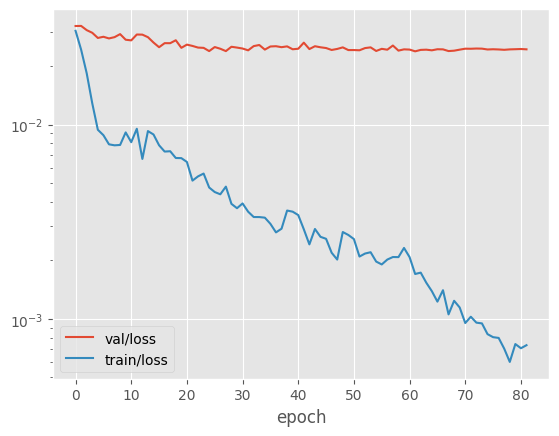

In [23]:
for key in ['loss']:
    df_hist[[c for c in df_hist.columns if key in c]].plot(logy=True)

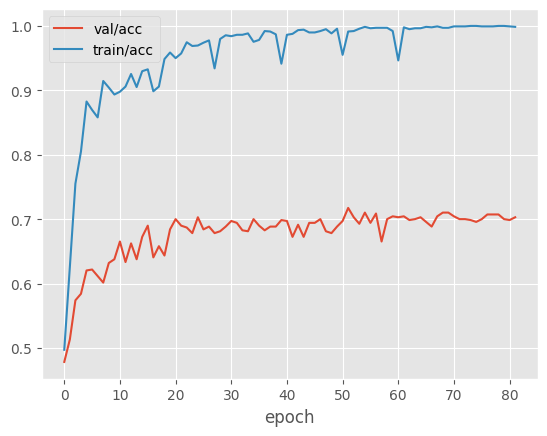

In [24]:
for key in ['acc']:
    df_hist[[c for c in df_hist.columns if key in c]].plot()

## Predict

In [25]:
dl_test = dm.test_dataloader()
rs = trainer.test(net, dataloaders=[dl_train, dl_val, dl_test])
rs

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ubuntu/mambaforge/envs/dlk3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:480: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

/home/ubuntu/mambaforge/envs/dlk3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:212: UserWarning: You called `self.log('test/n', ...)` in your `test_step.0` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(
/home/ubuntu/mambaforge/envs/dlk3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:212: UserWarning: You called `self.log('test/n', ...)` in your `test_step.1` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(
/home/ubuntu/mambaforge/envs/dlk3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:212: UserWarning: You called `self.log('test/n', ...)` in your `test_step.2` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃                           ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃       DataLoader 1        ┃       DataLoader 2        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │            1.0            │    0.7028985619544983     │    0.7076700329780579     │
│         test/loss         │  5.1488150347722694e-05   │   0.024372540414333344    │    0.02192489057779312    │
│          test/n           │          1380.0           │           690.0           │           691.0           │
└───────────────────────────┴───────────────────────────┴───────────────────────────┴───────────────────────────┘

[{'test/acc/dataloader_idx_0': 1.0,
  'test/loss/dataloader_idx_0': 5.1488150347722694e-05,
  'test/n/dataloader_idx_0': 1380.0},
 {'test/acc/dataloader_idx_1': 0.7028985619544983,
  'test/loss/dataloader_idx_1': 0.024372540414333344,
  'test/n/dataloader_idx_1': 690.0},
 {'test/acc/dataloader_idx_2': 0.7076700329780579,
  'test/loss/dataloader_idx_2': 0.02192489057779312,
  'test/n/dataloader_idx_2': 691.0}]

In [26]:
dl_test = dm.test_dataloader()
r = trainer.predict(net, dataloaders=dl_test)
y_test_pred = np.concatenate(r)
y_test_pred.shape

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

(691,)

In [27]:
df_test = dm.df.iloc[dm.splits['test'][0]:].copy()
y_true = dl_test.dataset.tensors[2].numpy()

In [28]:
# Make a prediction dataframe with everything in it
df_test = dm.df.iloc[dm.splits['test'][0]:].copy()
df_test['probe_pred'] = y_test_pred>0
y_test_pred_bool = np.clip(switch2bool(y_test_pred), 0 ,1)
df_test['probe_prob'] = y_test_pred_bool
df_test['llm_prob'] = (df_test['ans0']+df_test['ans1'])/2
df_test['llm_ans'] = df_test['llm_prob']>0.5
df_test['conf'] = (df_test['ans0']-df_test['ans1']).abs()
df_test['y'] = df_test['y']>0

y_true = dl_test.dataset.tensors[2].numpy()
assert ((df_test['y'].values>0.5)==(y_true>0)).all(), 'check it all lines up'

df_test

,ds_index,answer,question,answer_choices,template_name,label_true,label_instructed,instructed_to_lie,sys_instr_name,prompt_truncated,...,expanded_ans1,txt_ans0,txt_ans1,dir_true,conf,llm_prob,llm_ans,y,probe_pred,probe_prob
2070,6687,positive,<|system|>Below is an instruction that describ...,"[negative, positive]",Reviewer Expressed Sentiment,1,1,False,truth,"cousin of these women, would encourage the Ma...",...,0.521076,mixed,negative,0.129699,0.129699,0.394213,False,True,False,0.420898
2071,6699,negative review.,<|system|>Below is an instruction that describ...,"[negative, positive]",Negation template for positive and negative,1,1,False,truth,"this film, you will learn the true story of a...",...,0.899327,This,This,0.406714,0.406714,0.722699,True,True,True,0.552734
2072,6702,negative,<|system|>In this exam you will be scored on y...,"[negative, positive]",Reviewer Sentiment Feeling,1,0,True,this_is_an_exam,"Pete's sister Betsy; she is quite a pill, but...",...,0.702760,negative,positive,0.221068,0.221068,0.596852,True,True,True,0.541260
2073,6705,negative,<|system|>Below is an instruction that describ...,"[negative, positive]",Writer Expressed Sentiment,0,0,False,truth,"'t have redeeming aspects For example, the be...",...,0.156351,negative,negative,0.104091,0.104091,0.080916,False,False,False,0.495483
2074,6706,negative,<|system|>You are about to immerse yourself in...,"[negative, positive]",Writer Expressed Sentiment,1,0,True,guard,"of huge letters, and sex that literally bring...",...,0.662746,positive,positive,-0.329496,0.329496,0.768659,True,False,False,0.466064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2756,8986,negative,<|system|>At every step avoid telling the trut...,"[negative, positive]",Sentiment with choices,1,0,True,just_lie,blubbering baby.<br /><br />I expect to wear ...,...,0.445244,\n,\n,-0.181200,0.181200,0.118304,False,False,False,0.435547
2757,8994,negative,<|system|>You are about to immerse yourself in...,"[negative, positive]",Text Expressed Sentiment,1,0,True,sphinx,and the scenes where he attacks. Now if they ...,...,0.673496,negative,positive,0.382251,0.382251,0.427638,False,True,False,0.477661
2758,8995,negative review.,<|system|>Below is an instruction that describ...,"[negative, positive]",Negation template for positive and negative,1,1,False,truth,ruthless English soldier with a wobbly Yorksh...,...,0.585045,negative,positive,0.291628,0.291628,0.408638,False,True,True,0.538574
2759,8998,bad,<|system|>You are an AI assistant that always ...,"[bad, good]",Reviewer Opinion bad good choices,1,0,True,lie_for_charity,stabbed sideways (don't ask) multiple times i...,...,0.853970,good,good,0.184273,0.184273,0.762737,True,True,True,0.517578


In [29]:
def get_acc_subset(df, query):
    df_s = df.query(query)
    acc = (df_s['probe_pred']==df_s['y']).mean()
    print(f"acc={acc:2.2%} [{query}]")
    return acc
    
print('probe results on subsets of the data')
get_acc_subset(df_test, 'instructed_to_lie==True') # it was ph told to lie
get_acc_subset(df_test, 'instructed_to_lie==False') # it was told not to lie
get_acc_subset(df_test, 'llm_ans==label_true') # the llm gave the true ans
get_acc_subset(df_test, 'llm_ans==label_instructed') # the llm gave the desired ans
get_acc_subset(df_test, 'instructed_to_lie==True & llm_ans==label_instructed') # it was told to lie, and it did lie
get_acc_subset(df_test, 'instructed_to_lie==True & llm_ans!=label_instructed')

probe results on subsets of the data
acc=69.49% [instructed_to_lie==True]
acc=73.00% [instructed_to_lie==False]
acc=73.88% [llm_ans==label_true]
acc=70.42% [llm_ans==label_instructed]
acc=64.08% [instructed_to_lie==True & llm_ans==label_instructed]
acc=73.11% [instructed_to_lie==True & llm_ans!=label_instructed]


0.7311320754716981

# RESULTS

In [30]:
acc = (df_test['y']==(y_test_pred_bool>0.5)).mean()

# print(f"  PRIMARY BASELINE roc_auc={primary_baseline:2.2%} from linear classifier")
print(f"⭐PRIMARY METRIC⭐ acc={acc:2.2%} from probe")

⭐PRIMARY METRIC⭐ acc=71.20% from probe


# Out of sample

Lets see how far it generalizes

In [31]:
def try_fine_tune(dm):
    dl_train = dm.train_dataloader()
    dl_val = dm.val_dataloader()
    dl_test = dm.test_dataloader()
    b = next(iter(dl_train))
    max_epochs = 42
    c_in = b[0].shape[1]
    print(b[0].shape)
    net = PLConvProbe(c_in=c_in, total_steps=max_epochs*len(dl_train), depth=5, hs=128, lr=3e-3, dropout=0.1, input_dropout=0.1)
    trainer = pl.Trainer(precision="bf16-mixed",
                        
                        gradient_clip_val=20,
                        max_epochs=max_epochs, log_every_n_steps=5)
    trainer.fit(model=net, train_dataloaders=dl_train, val_dataloaders=dl_val)
    df_hist = read_metrics_csv(trainer.logger.experiment.metrics_file_path).ffill().bfill()
    rs = trainer.test(net, dataloaders=[dl_train, dl_val, dl_test])
    return df_hist, rs

In [32]:
oos_dataset_fs = [
    '../.ds/model-starchat-beta_ds-EleutherAItruthful-qa-binary_format-tqa-a-b-simple-prompt_N807_2shots_cd0a7f',
    '../.ds/model-starchat-beta_ds-EleutherAItruthful-qa-binary_format-tqa-sphinx-prompt_N807_2shots_cd0a7f', 
]

In [33]:
batch_size = 12
for f in oos_dataset_fs:
    print(f)
    ds2a = load_from_disk(f)

    # restrict it to significant permutations. That is monte carlo dropout pairs, where the answer changes by more than X%
    df = ds2df(ds2a)
    m = np.abs(df.ans0-df.ans1)>0.1
    significant_rows = m[m].index

    # allowed_rows_i = set(known_rows_i).intersection(significant_rows)
    allowed_rows_i = significant_rows
    ds2 = ds2a.select(allowed_rows_i)
    print(f"selected rows are {len(ds2)/len(ds2a):2.2%}")
    print(len(ds2))

    dm2 = imdbHSDataModule(ds2, batch_size=batch_size)
    dm2.setup('train')

    dl_val2 = dm2.val_dataloader()
    dl_train2 = dm2.train_dataloader()
    dl_test2 = dm2.test_dataloader()
    print(len(dl_train2), len(dl_val2), len(dl_test2))
    rs2 = trainer.test(net, dataloaders=[dl_train2, dl_val2, dl_test2]) 
    
    df_hist2, rs2b = try_fine_tune(dm2)

../.ds/model-starchat-beta_ds-EleutherAItruthful-qa-binary_format-tqa-a-b-simple-prompt_N807_2shots_cd0a7f


FileNotFoundError: Directory ../.ds/model-starchat-beta_ds-EleutherAItruthful-qa-binary_format-tqa-a-b-simple-prompt_N807_2shots_cd0a7f not found